In [2]:
from google.colab import drive
drive.mount("/content/drive")

%matplotlib inline

Mounted at /content/drive


In [3]:
import numpy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf



In [4]:


def init_dataset():
  numpy.random.seed(1)
  dataframe = read_csv('drive/My Drive/Colab Notebooks/code/deep/Google_Stock_Price_Train.csv', usecols=[1,2,3,4,5], engine='python' , thousands=',')
  dataset = dataframe.values
  dataset = dataset.astype('float32')
  return dataset

def preprocessing(dataset):
  # normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset)
  return scaler , dataset

def separate_data(dataset):
  train_size = int(len(dataset) * 0.67)
  valid_size = len(dataset) - train_size
  train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  return train , valid


def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), :5]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)

def lstm_model(trainX , trainY , validX , validY , epochs , look_back , batch_size , n_neurons):
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

  model = Sequential()
  model.add(LSTM(n_neurons, input_shape=(look_back , 5)))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  
  history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[callback] , validation_data=(validX , validY))

  return model, history

def calculate_rmse(Y , predict , name):
  score = math.sqrt(mean_squared_error(Y[:], predict[:]))
  print(name , 'Score: %.2f RMSE' % (score))
  return score

def repeat_inverse_transform(scaler , Y , dim):
  Y = np.repeat(Y, 5 , axis=1)
  Y = scaler.inverse_transform(Y)
  if dim == 0:
    Y = Y[:,0].reshape(Y.shape[0],)
  else:
    Y = Y[:,0]
  return Y

def get_rmse_arr(scaler , trainX_ori , trainY_ori , validX_ori, validY_ori, look_back , n_epochs , batch_size, n_neurons):
  train_scores = list()
  valid_scores = list()

  model, history = lstm_model(trainX_ori , trainY_ori, validX_ori, validY_ori , n_epochs , look_back , batch_size , n_neurons)
  
  # make predictions
  trainPredict = model.predict(trainX_ori)
  validPredict = model.predict(validX_ori)
  # invert predictions
  trainPredict = repeat_inverse_transform(scaler , trainPredict , 1)
  trainY = repeat_inverse_transform(scaler , trainY_ori.reshape(trainY_ori.shape[0],1) , 0)
  validPredict = repeat_inverse_transform(scaler , validPredict , 1)
  validY = repeat_inverse_transform(scaler , validY_ori.reshape(validY_ori.shape[0],1) , 0)

  #train_score = calculate_rmse(trainY , trainPredict , "Train")
  #valid_score = calculate_rmse(validY , validPredict , "Valid")

  mse = tf.keras.losses.MeanSquaredError()
  train_score_mse = np.sqrt(mse(trainY, trainPredict).numpy())
  valid_score_mse = np.sqrt(mse(validY, validPredict).numpy())

  train_scores.append(train_score_mse)
  valid_scores.append(valid_score_mse)


  print("train_scores" , train_scores)
  print("valid_scores" , valid_scores)

  return trainPredict , validPredict , train_score_mse , valid_score_mse , history

def plot_prediction(scaler , dataset , trainPredict , validPredict , look_back , title):
  # shift train predictions for plotting
  trainPredictPlot = numpy.empty_like(dataset[:,0])
  trainPredictPlot[:] = numpy.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict
  # shift valid predictions for plotting
  validPredictPlot = numpy.empty_like(dataset[:,0])
  validPredictPlot[:] = numpy.nan
  validPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1] = validPredict
  # plot baseline and predictions
  fig1 = plt.figure(1)
  plt.plot(scaler.inverse_transform(dataset)[:,0])
  plt.plot(trainPredictPlot)
  plt.plot(validPredictPlot)
  plt.title(title)
  plt.show()


def train_model(title , index , look_backs , repeat , n_epochs , batch_size_arr , n_neurons_arr):
  n_search_arr = []
  look_back = look_backs[0]
  if index == 1:
    n_search_arr = look_backs
  elif index == 2:
    n_search_arr = batch_size_arr
  elif index == 3:
    n_search_arr = n_neurons_arr


  train_scores_arr = np.zeros(( repeat , len(n_search_arr)))
  valid_scores_arr = np.zeros(( repeat , len(n_search_arr)))
  dataset = init_dataset()
  trainPredict , validPredict = list() , list()
  scaler , dataset = preprocessing(dataset)
  train , valid = separate_data(dataset)

  if index != 0:
    for i in range(repeat):
      # reshape into X=t and Y=t+1
      for neurons_size_index in range(len(n_search_arr)):
        batch_size = batch_size_arr[0]
        n_neurons = n_search_arr[0]
        if index == 1:
          look_back = n_search_arr[neurons_size_index]
        elif index == 2:
          batch_size = n_search_arr[neurons_size_index]
        elif index == 3:
          n_neurons = n_search_arr[neurons_size_index]

        trainX, trainY = create_dataset(train, look_back)
        validX, validY = create_dataset(valid, look_back)
        print(trainX.shape)
        print(trainY.shape)
        # reshape input to be [samples, time steps, features]
        #trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        #validX = numpy.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
        

        trainPredict , validPredict , train_scores , valid_scores , history = get_rmse_arr(scaler , trainX , trainY ,validX, validY, look_back , n_epochs , batch_size , n_neurons)
        train_scores_arr[i , neurons_size_index ] = train_scores
        valid_scores_arr[i , neurons_size_index ] = valid_scores
      print("train_scores_arr")
      print(train_scores_arr)
      print("valid_scores_arr")
      print(valid_scores_arr)

    train_scores_arr_df = pd.DataFrame(train_scores_arr , columns=n_search_arr)
    fig = plt.figure(4, figsize=(9, 6))
    train_scores_arr_df.boxplot(column = n_search_arr)
    plt.title("train rmse with diff batch")
    plt.show()

    valid_scores_arr_df = pd.DataFrame(valid_scores_arr , columns=n_search_arr)
    fig = plt.figure(5, figsize=(9, 6))
    valid_scores_arr_df.boxplot(column = n_search_arr)
    plt.title("valid rmse with diff batch")
    plt.show()
  else:
    trainX, trainY = create_dataset(train, look_back)
    validX, validY = create_dataset(valid, look_back)

    trainPredict , validPredict , train_scores , valid_scores , history = get_rmse_arr(scaler , trainX , trainY ,validX, validY, look_back , n_epochs , batch_size_arr[0] , n_neurons_arr[0])
    
    plot_prediction(scaler , dataset , trainPredict , validPredict , look_back , title)
    print(" for batch size = 1, both train set and valid set has a small average loss and a small deviation")
    print("train_scores , valid_scores")
    print(train_scores , valid_scores)


(840, 1, 5)
(840,)
train_scores [6.1354017]
valid_scores [52.581593]
(839, 2, 5)
(839,)
train_scores [7.369589]
valid_scores [80.73107]
(838, 3, 5)
(838,)
train_scores [6.5070286]
valid_scores [40.250618]
train_scores_arr
[[6.13540173 7.36958885 6.50702858]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
valid_scores_arr
[[52.58159256 80.73107147 40.25061798]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
(840, 1, 

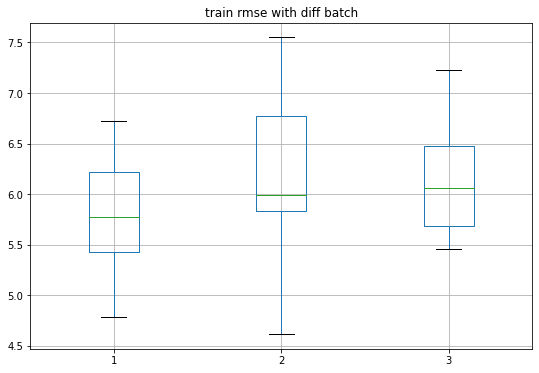

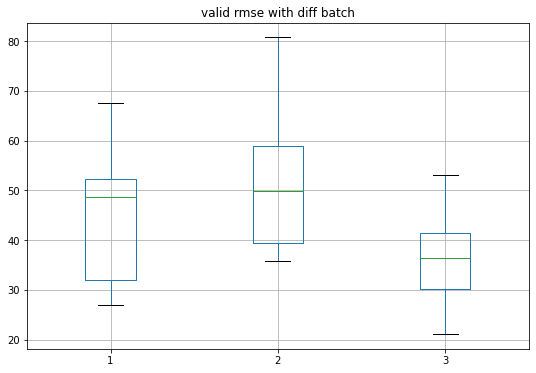

1186.9222419261932
s


In [16]:
repeats = 10
n_epochs = 100

look_backs = [1,2,3]
n_batch = [1]
n_neurons = [8]


import time
tic = time.time()
# entry point
title = "batch=" + str(n_batch[0]) + " look_back=" + str(look_backs[0]) + " neurons=" + str(n_neurons[0])
index = 1
train_model(title, index , look_backs , repeats , n_epochs , n_batch, n_neurons)
toc = time.time()
print(toc - tic)
print("s")




train_scores [7.2584853]
valid_scores [23.327675]


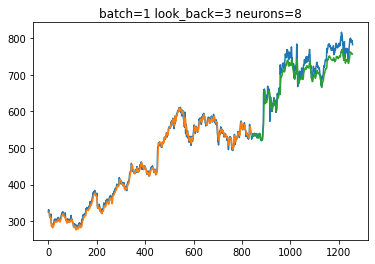

 for batch size = 1, both train set and valid set has a small average loss and a small deviation
train_scores , valid_scores
7.2584853 23.327675
10.372277975082397
s


In [17]:
repeats = 10
n_epochs = 100

look_backs = [3]
n_batch = [1]
n_neurons = [8]


import time
tic = time.time()
# entry point
title = "batch=" + str(n_batch[0]) + " look_back=" + str(look_backs[0]) + " neurons=" + str(n_neurons[0])
index = 0
train_model(title, index , look_backs , repeats , n_epochs , n_batch, n_neurons)
toc = time.time()
print(toc - tic)
print("s")




(838, 3, 5)
(838,)
train_scores [6.4475393]
valid_scores [19.465816]
(838, 3, 5)
(838,)
train_scores [5.336319]
valid_scores [34.54151]
(838, 3, 5)
(838,)
train_scores [7.542465]
valid_scores [63.318172]
(838, 3, 5)
(838,)
train_scores [5.660654]
valid_scores [30.212828]
train_scores_arr
[[6.44753933 5.33631897 7.54246521 5.66065407]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
valid_scores_arr
[[19.4658165  34.54151154 63.31817245 30.21282768]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.  

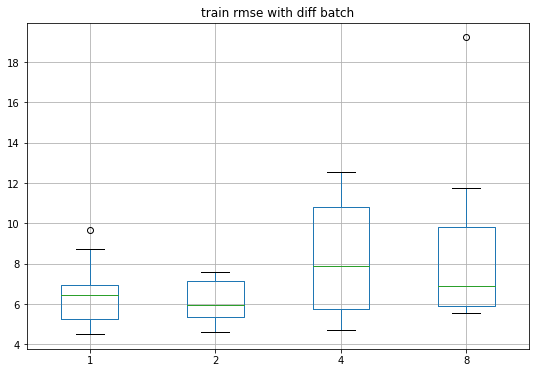

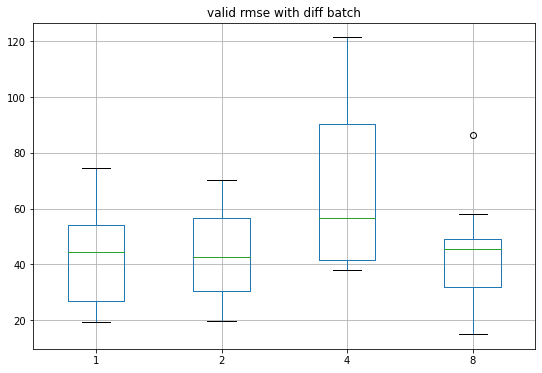

1113.6712357997894
s


In [5]:
repeats = 10
n_epochs = 100

look_backs = [3]
n_batch = [1,2,4,8]
n_neurons = [8]


import time
tic = time.time()
# entry point
title = "batch=" + str(n_batch[0]) + " look_back=" + str(look_backs[0]) + " neurons=" + str(n_neurons[0])
index = 2
train_model(title, index , look_backs , repeats , n_epochs , n_batch, n_neurons)
toc = time.time()
print(toc - tic)
print("s")




train_scores [6.2982297]
valid_scores [26.669119]


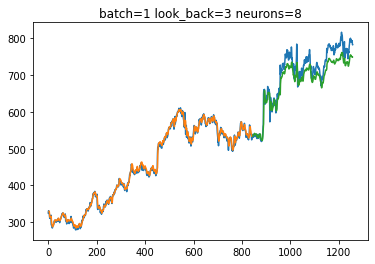

 for batch size = 1, both train set and valid set has a small average loss and a small deviation
train_scores , valid_scores
6.2982297 26.669119
15.650978088378906
s


In [7]:
repeats = 10
n_epochs = 100

look_backs = [3]
n_batch = [1]
n_neurons = [8]


import time
tic = time.time()
# entry point
title = "batch=" + str(n_batch[0]) + " look_back=" + str(look_backs[0]) + " neurons=" + str(n_neurons[0])
index = 0
train_model(title, index , look_backs , repeats , n_epochs , n_batch, n_neurons)
toc = time.time()
print(toc - tic)
print("s")




(838, 3, 5)
(838,)
train_scores [6.885123]
valid_scores [49.622795]
(838, 3, 5)
(838,)
train_scores [7.647738]
valid_scores [36.891632]
(838, 3, 5)
(838,)
train_scores [5.9226475]
valid_scores [26.253017]
(838, 3, 5)
(838,)
train_scores [6.3299723]
valid_scores [21.506699]
train_scores_arr
[[6.88512278 7.64773798 5.92264748 6.32997227]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
valid_scores_arr
[[49.6227951  36.89163208 26.25301743 21.50669861]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.

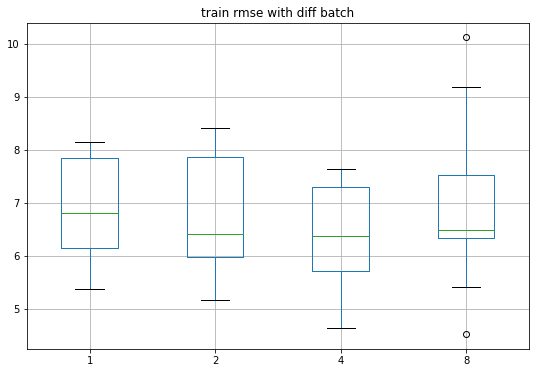

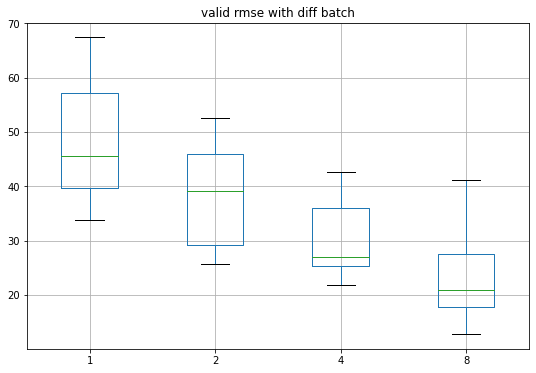

1019.1271555423737
s


In [8]:
repeats = 10
n_epochs = 100

look_backs = [3]
n_batch = [1]
n_neurons = [1,2,4,8]


import time
tic = time.time()
# entry point
title = "batch=" + str(n_batch[0]) + " look_back=" + str(look_backs[0]) + " neurons=" + str(n_neurons[0])
index = 3
train_model(title, index , look_backs , repeats , n_epochs , n_batch, n_neurons)
toc = time.time()
print(toc - tic)
print("s")




train_scores [6.5717006]
valid_scores [26.458044]


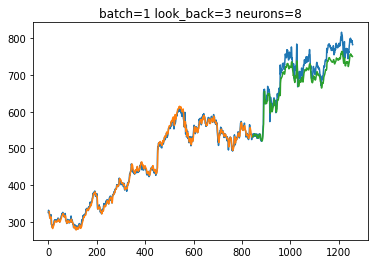

 for batch size = 1, both train set and valid set has a small average loss and a small deviation
train_scores , valid_scores
6.5717006 26.458044
15.990616083145142
s


In [9]:
repeats = 10
n_epochs = 100

look_backs = [3]
n_batch = [1]
n_neurons = [8]


import time
tic = time.time()
# entry point
title = "batch=" + str(n_batch[0]) + " look_back=" + str(look_backs[0]) + " neurons=" + str(n_neurons[0])
index = 0
train_model(title, index , look_backs , repeats , n_epochs , n_batch, n_neurons)
toc = time.time()
print(toc - tic)
print("s")




multi-layer rnn , not work
beause the shape of output of model is (1,), we need to output all the 5 features at lower layers.

In [28]:
def lstm_model(trainX , trainY , validX , validY , epochs , look_back , batch_size , n_neurons):
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

  model = Sequential()
  model.add(LSTM(n_neurons, return_sequences=True , input_shape=(look_back , 5)))
  model.add(LSTM(n_neurons, return_sequences=True))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  
  history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[callback] , validation_data=(validX , validY))

  return model, history


Bidirectional

train_scores [7.752059]
valid_scores [25.23874]


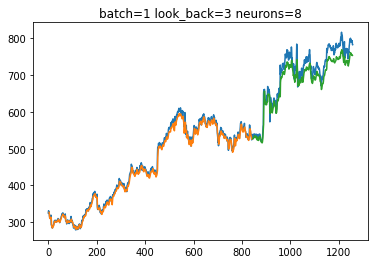

 for batch size = 1, both train set and valid set has a small average loss and a small deviation
train_scores , valid_scores
7.752059 25.23874
22.988410472869873
s


In [36]:
from keras.layers import Bidirectional

def lstm_model(trainX , trainY , validX , validY , epochs , look_back , batch_size , n_neurons):
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

  model = Sequential()
  model.add(Bidirectional(LSTM(n_neurons, input_shape=(look_back , 5))))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  
  history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[callback] , validation_data=(validX , validY))

  return model, history



repeats = 10
n_epochs = 100

look_backs = [3]
n_batch = [1]
n_neurons = [8]


import time
tic = time.time()
# entry point
title = "batch=" + str(n_batch[0]) + " look_back=" + str(look_backs[0]) + " neurons=" + str(n_neurons[0])
index = 0
train_model(title, index , look_backs , repeats , n_epochs , n_batch, n_neurons)
toc = time.time()
print(toc - tic)
print("s")




Predict Test set

(16,)
(16,)
test score is  554.151
plot_test_prediction
(20, 5)
(16,)


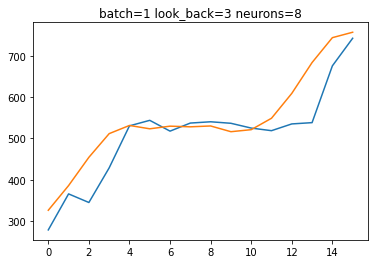

15.044504880905151
s


In [41]:
def init_test_dataset():
  # fix random seed for reproducibility
  numpy.random.seed(7)
  # load the dataset
  dataframe = read_csv('drive/My Drive/Colab Notebooks/code/deep/Google_Stock_Price_Test.csv', usecols=[1,2,3,4,5], engine='python' , thousands=',')
  dataset = dataframe.values
  dataset = dataset.astype('float32')
  return dataset

def get_test_rmse_arr(scaler , trainX_ori , trainY_ori , validX_ori, validY_ori, look_back , n_epochs , batch_size, n_neurons):
  train_scores = list()
  valid_scores = list()

  model, history = lstm_model(trainX_ori , trainY_ori, validX_ori, validY_ori , n_epochs , look_back , batch_size , n_neurons)
  
  # make predictions
  trainPredict = model.predict(trainX_ori)
  validPredict = model.predict(validX_ori)
  # invert predictions
  trainPredict = repeat_inverse_transform(scaler , trainPredict , 1)
  trainY = repeat_inverse_transform(scaler , trainY_ori.reshape(trainY_ori.shape[0],1) , 0)
  validPredict = repeat_inverse_transform(scaler , validPredict , 1)
  validY = repeat_inverse_transform(scaler , validY_ori.reshape(validY_ori.shape[0],1) , 0)

  #train_score = calculate_rmse(trainY , trainPredict , "Train")
  #valid_score = calculate_rmse(validY , validPredict , "Valid")

  mse = tf.keras.losses.MeanSquaredError()
  train_score_mse = np.sqrt(mse(trainY, trainPredict).numpy())
  valid_score_mse = np.sqrt(mse(validY, validPredict).numpy())

  train_scores.append(train_score_mse)
  valid_scores.append(valid_score_mse)



  return trainPredict , validPredict , train_score_mse , valid_score_mse , history , model

def plot_test_prediction(scaler , test_dataset , testPredict , look_back , title):
  print("plot_test_prediction")
  print(test_dataset.shape)
  print(testPredict.shape)
  # shift train predictions for plotting
  #testPredictPlot = numpy.empty_like(test_dataset[:,0])
  #testPredictPlot[:] = numpy.nan
  #testPredictPlot[look_back:len(testPredict)+look_back] = testPredict

  # plot baseline and predictions
  fig1 = plt.figure(1)
  plt.plot(scaler.inverse_transform(test_dataset[:len(testPredict)])[:,0])
  plt.plot(testPredict)
  plt.title(title)
  plt.show()


def train_test_model(title , index , look_backs , repeat , n_epochs , batch_size_arr , n_neurons_arr):

  dataset = init_dataset()
  trainPredict , validPredict = list() , list()
  scaler , dataset = preprocessing(dataset)
  train , valid = separate_data(dataset)

  trainX, trainY = create_dataset(train, look_backs[0])
  validX, validY = create_dataset(valid, look_backs[0])

  trainPredict , validPredict , train_scores , valid_scores , history , model = get_test_rmse_arr(scaler , trainX , trainY ,validX, validY, look_backs[0] , n_epochs , batch_size_arr[0] , n_neurons_arr[0])

  test_dataset = init_test_dataset()
  testPredict = list()
  test_scaler , test_dataset = preprocessing(test_dataset)

  
  testX, testY = create_dataset(test_dataset, look_backs[0])
  testPredict = model.predict(testX)
  testPredict = repeat_inverse_transform(scaler , testPredict , 1)

  mse = tf.keras.losses.MeanSquaredError()
  test_score_mse = np.sqrt(mse(testY, testPredict).numpy())

  print("test score is " , test_score_mse)
  plot_test_prediction(scaler , test_dataset , testPredict , look_backs[0] , title)



repeats = 10
n_epochs = 100

look_backs = [3]
n_batch = [1]
n_neurons = [8]


import time
tic = time.time()
# entry point
title = "batch=" + str(n_batch[0]) + " look_back=" + str(look_backs[0]) + " neurons=" + str(n_neurons[0])
index = 0
train_test_model(title, index , look_backs , repeats , n_epochs , n_batch, n_neurons)
toc = time.time()
print(toc - tic)
print("s")


